### Run QG model to equilibrium and plot KE & PV

Spin up QG model and save equilibriated state. We will use `run_with_snapshots` and `get_diagnostic` to save the PV anomaly and mean eddy kinetic energy.

TODO: encode parameters in a config file

Notebooks:
1. Single ensemble member with parameter [n] for randomness and save data
2. Analysis load EMs

In [1]:
import numpy as np
import xarray as xr
import pyqg
from pyqg import diagnostic_tools as tools
from pyqg import qg_model, particles
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
from numpy.random import RandomState, SeedSequence

#### Ensemble Member 1

In [2]:
# Set parameters & initialize model
year = 24*60*60*360.
twrite = 1000
tavestart = 2*year

# Initialize QG Model
m = pyqg.QGModel(tmax=20*year, twrite=twrite, tavestart=tavestart)

# Container for the BitGenerator with initialized random number generator
# REF: https://numpy.org/doc/stable/reference/random/generator.html
rg = Generator(MT19937(SeedSequence(123456789)))

# set upper and lower PV anomaly in spatial coordinates
sig = 1.e-6
qi = sig*np.vstack([rg.random((m.nx,m.ny))[np.newaxis,],
                  rg.random((m.nx,m.ny))[np.newaxis,]])

m.set_q(qi) 


INFO:  Logger initialized


In [3]:
def test():
    '''Test the random seed generator.'''
    rg = Generator(MT19937(SeedSequence(123456789)))
    rn1 = rg.random(10)
    
    rg = Generator(MT19937(SeedSequence(123456789)))
    rn2 = rg.random(10)
    
    print(rg)
    comparison = rn1 == rn2

    assert comparison.all(),"Random numbers in each set are different."
    
test()

Generator(MT19937)


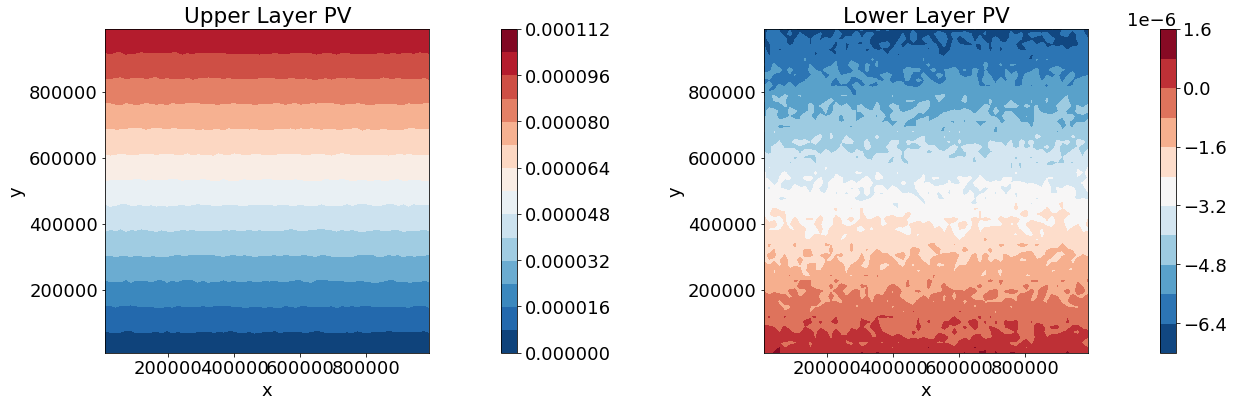

In [4]:
# Plot initialized PV on ensemble member 1
qi_upper = m.q[0] + m.Qy[0]*m.y
qi_lower = m.q[1] + m.Qy[1]*m.y

plt.figure(figsize=(18,6))
plt.rcParams.update({'font.size': 18})

plt.subplot(121)
plt.contourf(m.x, m.y, qi_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar(); plt.axis('square')

plt.subplot(122)
plt.contourf(m.x, m.y, qi_lower, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Layer PV')
plt.colorbar(); plt.axis('square')

plt.tight_layout();

#### Run model to equilibrium

TODO: use m.to_dataset()

Is this included in the latest release?

In [5]:
m.to_dataset()

AttributeError: 'QGModel' object has no attribute 'to_dataset'

In [6]:
# Initialize lists for the PV anomaly and EKE
q = [qi]
eke = [[np.nan, np.nan]]
t = [0]

for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
    q_copy = m.q.copy() 
    q.append(q_copy) # PV anomaly
    t.append(m.t) # model time
    try:
        eke.append(m.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke.append([np.nan, np.nan])
        
# Convert to numpy arrays        
q_snapshots = np.stack(q)
EKE_snapshots = np.stack(eke)
t_snapshots = np.stack(t)

INFO: Step: 1000, Time: 7.20e+06, KE: 4.19e-07, CFL: 0.014
INFO: Step: 2000, Time: 1.44e+07, KE: 6.96e-07, CFL: 0.013
INFO: Step: 3000, Time: 2.16e+07, KE: 1.39e-06, CFL: 0.014
INFO: Step: 4000, Time: 2.88e+07, KE: 3.15e-06, CFL: 0.015
INFO: Step: 5000, Time: 3.60e+07, KE: 7.67e-06, CFL: 0.017
INFO: Step: 6000, Time: 4.32e+07, KE: 1.94e-05, CFL: 0.019
INFO: Step: 7000, Time: 5.04e+07, KE: 4.90e-05, CFL: 0.028
INFO: Step: 8000, Time: 5.76e+07, KE: 1.15e-04, CFL: 0.046
INFO: Step: 9000, Time: 6.48e+07, KE: 2.08e-04, CFL: 0.065
INFO: Step: 10000, Time: 7.20e+07, KE: 2.61e-04, CFL: 0.068
INFO: Step: 11000, Time: 7.92e+07, KE: 3.16e-04, CFL: 0.076
INFO: Step: 12000, Time: 8.64e+07, KE: 3.88e-04, CFL: 0.078
INFO: Step: 13000, Time: 9.36e+07, KE: 4.09e-04, CFL: 0.078
INFO: Step: 14000, Time: 1.01e+08, KE: 4.38e-04, CFL: 0.095
INFO: Step: 15000, Time: 1.08e+08, KE: 4.49e-04, CFL: 0.089
INFO: Step: 16000, Time: 1.15e+08, KE: 4.66e-04, CFL: 0.086
INFO: Step: 17000, Time: 1.22e+08, KE: 4.95e-04, 

#### Mean Eddy Kinetic Energy (EKE) as a function of time

model appears stable at time: 305596800.0


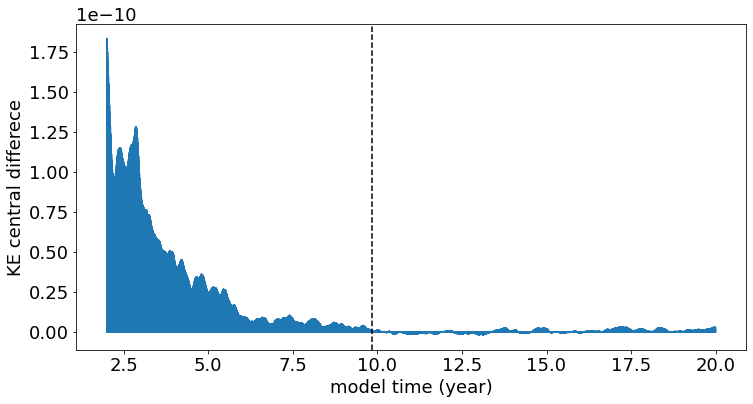

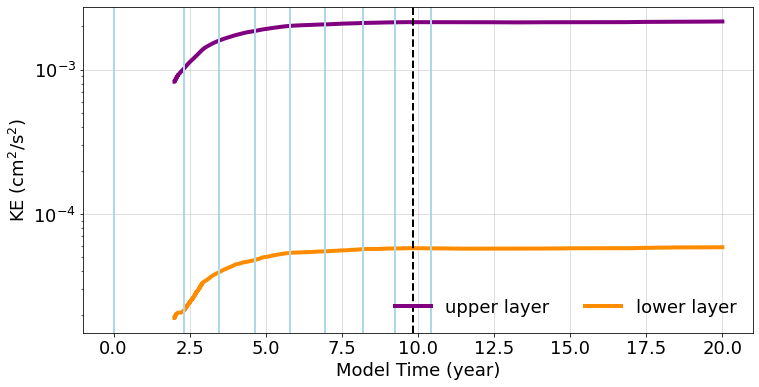

In [7]:
# Take derivative of upper layer EKE using a central difference
dEKE_dt = np.gradient(EKE_snapshots[:,0], t_snapshots)
I = np.where((dEKE_dt<0.01e-10)&(dEKE_dt>0)) [0]
EKE_stable = t_snapshots[I[0]]

# Plot EKE derivative
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,6)); plt.plot(t_snapshots/year, dEKE_dt)
plt.ylabel('KE central differece'); plt.xlabel('model time (year)')
plt.axvline(x=EKE_stable/year, color='k', linestyle='--')

print('model appears stable at time:', EKE_stable)

# Plot time series of EKE
plt.figure(figsize=(12,6))
plt.semilogy(t_snapshots/year, EKE_snapshots[:,0], lw=4, color='purple', label='upper layer')
plt.semilogy(t_snapshots/year, EKE_snapshots[:,1], lw=4, color='darkorange', label='lower layer')
ints = [0, 10000, 15000, 20000, 25000, 30000, 35388, 40000, 45000]
for i in ints:
    plt.axvline(x=t_snapshots[i]/year, color='lightblue', linewidth=2, alpha=1)
plt.axvline(x=EKE_stable/year, color='k', lw=2, linestyle='--')
plt.grid(True, alpha=0.5); plt.legend(frameon=False, ncol=2)
plt.ylabel(r'KE ($\rmcm^{2}$/$\rms^{2}$)'); plt.xlabel('Model Time (year)');

As the model gets spun up, the mean EKE increases until it reaches an equilibrated state. When the EKE plateaus the model is in a stable state. The dashed vertical line shows where the derivative first falls below a threshold (0.01e-10). This would be a good place to save the model state for the ensemble perturbation experiment.

Vertical light blue lines show times corresponding the the snapshots plotted below. 

### Evolution of the upper PV anomaly field

In [55]:
print('stable index ', int(np.where(t_snapshots == EKE_stable)[0]))

stable index  42444


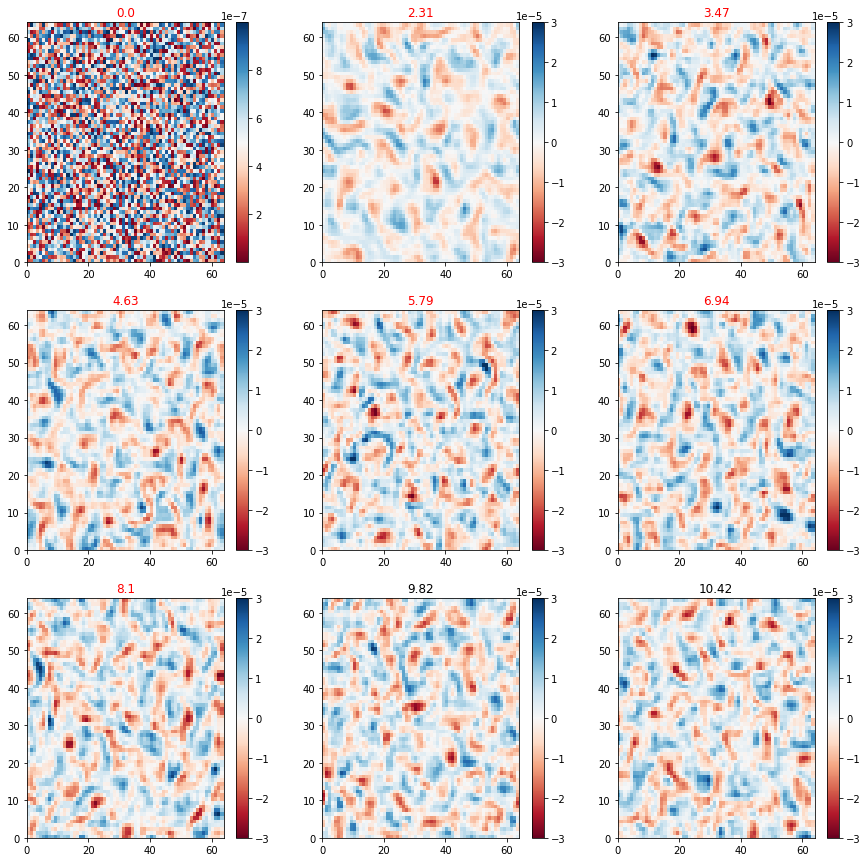

In [57]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['image.cmap'] = 'RdBu'

lev=0 # level 1
ints = [0, 10000, 15000, 20000, 25000, 30000, 35000, 42444, 45000]
plt.figure(figsize=(15,15))
for i in enumerate(ints):
    if i[1]==0:
        plt.subplot(3,3,i[0]+1)
        plt.pcolormesh(q[i[1]][lev,:,:])
        plt.title(round(t_snapshots[i[1]]/year, 2), color='r')
        plt.colorbar()
    else:
        plt.subplot(3,3,i[0]+1)
        plt.pcolormesh(q[i[1]][lev,:,:], vmin=-3e-5, vmax=3e-5)
        if i[0] < 7:
            plt.title(round(t_snapshots[i[1]]/year, 2), color='r')
        else:
            plt.title(round(t_snapshots[i[1]]/year, 2), color='k')
        plt.colorbar()


The PV field becomes stable after 9.82 years. The titles correspond to the model time in years. 

#### Save model state at equilibrium

In [41]:
year = 24*60*60*360.
twrite = 1000
tavestart = 2*year
tmax = EKE_stable

m_001 = pyqg.QGModel(tmax=tmax, twrite=twrite, tavestart=tavestart)

# Container for the BitGenerator with initialized random number generator
# REF: https://numpy.org/doc/stable/reference/random/generator.html
rg = Generator(MT19937(SeedSequence(123456789)))

# set upper and lower PV anomaly in spatial coordinates
sig = 1.e-6
qi = sig*np.vstack([rg.random((m_001.nx,m_001.ny))[np.newaxis,],
                  rg.random((m_001.nx,m_001.ny))[np.newaxis,]])

m_001.set_q(qi) 


INFO:  Logger initialized


In [42]:
%%time
m_001.run()

INFO: Step: 1000, Time: 7.20e+06, KE: 4.19e-07, CFL: 0.014
INFO: Step: 2000, Time: 1.44e+07, KE: 6.96e-07, CFL: 0.013
INFO: Step: 3000, Time: 2.16e+07, KE: 1.39e-06, CFL: 0.014
INFO: Step: 4000, Time: 2.88e+07, KE: 3.15e-06, CFL: 0.015
INFO: Step: 5000, Time: 3.60e+07, KE: 7.67e-06, CFL: 0.017
INFO: Step: 6000, Time: 4.32e+07, KE: 1.94e-05, CFL: 0.019
INFO: Step: 7000, Time: 5.04e+07, KE: 4.90e-05, CFL: 0.028
INFO: Step: 8000, Time: 5.76e+07, KE: 1.15e-04, CFL: 0.046
INFO: Step: 9000, Time: 6.48e+07, KE: 2.08e-04, CFL: 0.065
INFO: Step: 10000, Time: 7.20e+07, KE: 2.61e-04, CFL: 0.068
INFO: Step: 11000, Time: 7.92e+07, KE: 3.16e-04, CFL: 0.076
INFO: Step: 12000, Time: 8.64e+07, KE: 3.88e-04, CFL: 0.078
INFO: Step: 13000, Time: 9.36e+07, KE: 4.09e-04, CFL: 0.078
INFO: Step: 14000, Time: 1.01e+08, KE: 4.38e-04, CFL: 0.095
INFO: Step: 15000, Time: 1.08e+08, KE: 4.49e-04, CFL: 0.089
INFO: Step: 16000, Time: 1.15e+08, KE: 4.66e-04, CFL: 0.086
INFO: Step: 17000, Time: 1.22e+08, KE: 4.95e-04, 

CPU times: user 15.6 s, sys: 6.74 ms, total: 15.6 s
Wall time: 15.6 s


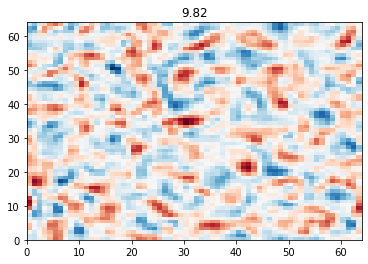

In [58]:
plt.pcolormesh(m_001.q[lev,:,:])
plt.title(round(m_001.t/year, 2));

In [59]:
m.to_dataset()

AttributeError: 'QGModel' object has no attribute 'to_dataset'

In [60]:
EKE_stable

305596800.0